<Quantity 277.69230769 mm>

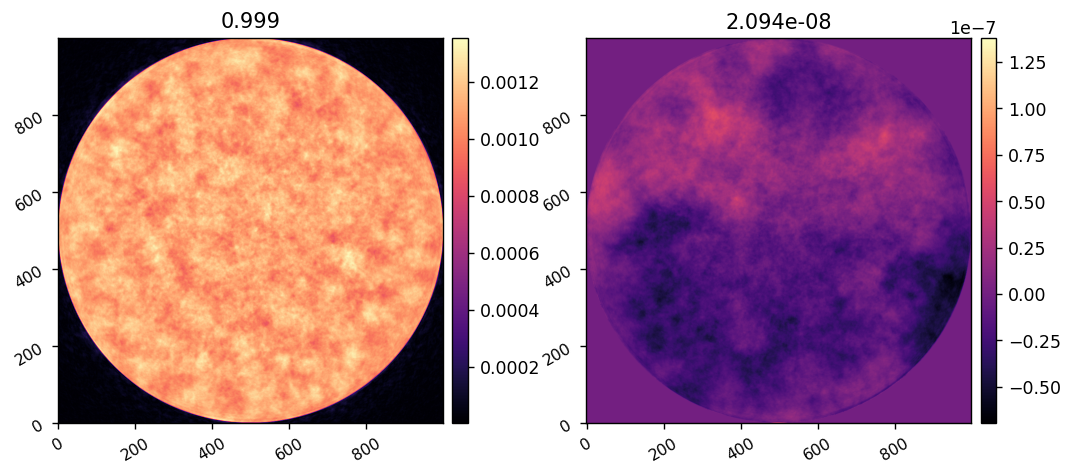

In [18]:
import numpy as np
import astropy.units as u
from astropy.io import fits
from matplotlib.patches import Rectangle, Circle
from pathlib import Path
from IPython.display import clear_output
from importlib import reload

import poppy
import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('DEBUG')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
poppy_log.disabled = True

import warnings
warnings.filterwarnings("ignore")

import apra_pop_models
import apra_pop_models.fraunhofer_coro_2dm as fraunhofer
from apra_pop_models.math_module import xp, _scipy, ensure_np_array
import apra_pop_models.utils as utils
import apra_pop_models.props as props

from apra_pop_models.imshows import *

pupil_diam = 9.5*u.mm
wavelength_c = 650e-9*u.m

FN = 500
optimal_dm1_dm2 = (pupil_diam**2/(wavelength_c*FN)).to(u.mm)
display(optimal_dm1_dm2)

reload(utils)
# WFE = utils.generate_wfe(diam=pupil_diam, npix=1000, oversample=1,
#                          opd_index=2.75, amp_index=2.75, 
#                          opd_seed=123, amp_seed=1234,
#                          opd_rms=25*u.nm, amp_rms=0.05, 
#                          wavelength=wavelength_c)

# wfe_mask = xp.abs(WFE)>0
# wfe_amp = xp.abs(WFE)
# wfe_opd = xp.angle(WFE)*wavelength_c.to_value(u.m)/(2*np.pi)
# rms_amp = xp.sqrt(xp.mean(xp.square(wfe_amp[wfe_mask]-1)))
# rms_opd = xp.sqrt(xp.mean(xp.square(wfe_opd[wfe_mask])))
# imshow2(wfe_amp, wfe_opd,  f'{rms_amp:.3f}', f'{rms_opd:.3e}')

WFE = xp.array(fits.getdata('../phase-retrieval-data/post_fpm_wfe_20240503.fits'))
WFE = WFE[0] * xp.exp(1j*2*np.pi*WFE[1]/wavelength_c.to_value(u.m))
wfe_amp = xp.abs(WFE)
wfe_opd = xp.angle(WFE)*wavelength_c.to_value(u.m)/(2*np.pi)
rms_amp = xp.sqrt(xp.mean(xp.square(wfe_amp[wfe_mask]-1)))
rms_opd = xp.sqrt(xp.mean(xp.square(wfe_opd[wfe_mask])))
imshow2(wfe_amp, wfe_opd,  f'{rms_amp:.3f}', f'{rms_opd:.3e}')


In [13]:
model.psf_pixelscale, model.um_per_lamD, model.psf_pixelscale_lamD

(<Quantity 5.e-06 m / pix>, <Quantity 28.50877193 um>, 0.17538461538461542)

influence function sampling 31.578947368421048
Using the influence function supplied.
Including factor of 2 from reflection when computing OPD.
Using the influence function supplied.
Including factor of 2 from reflection when computing OPD.
0.0005053052450140757


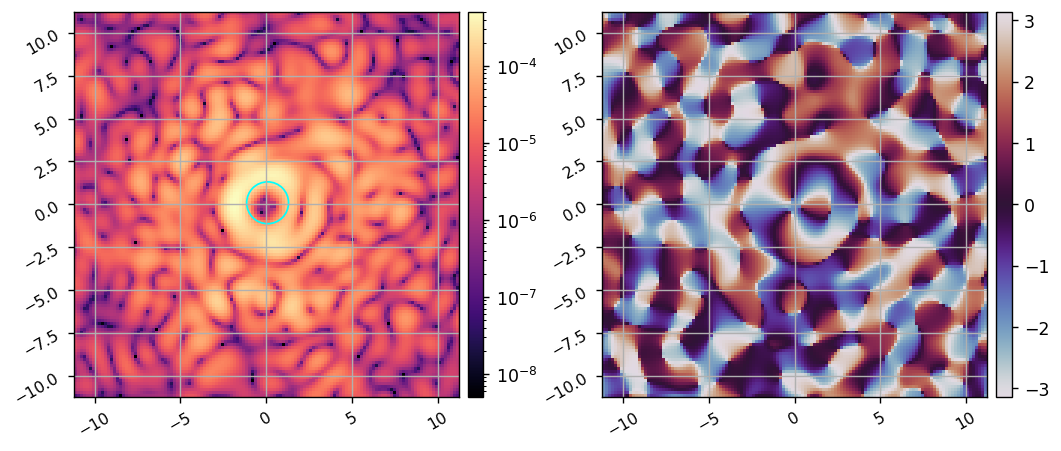

In [21]:
reload(fraunhofer)
reload(apra_pop_models.props)
model = fraunhofer.CORO()
# model.Imax_ref = 12448.951927281492

model.WFE = WFE
model.Imax_ref = 0.017874510571953023
# model.reverse_parity = True

# pup_ratio = model.pupil_diam.to_value(u.m)/model.dm_active_diam.to_value(u.m)
# xpp = (xp.arange(-model.Nact//2, model.Nact//2) + 1/2)/pup_ratio
# ppx, ppy = xp.meshgrid(xpp,xpp)
# amp = 5e-8
# separation = 5
# comm1 = amp*xp.cos(2*np.pi*(ppx + ppy)*separation/model.Nact)*xp.array(model.dm_mask)
# comm2 = amp*xp.cos(2*np.pi*(ppx - ppy)*separation/model.Nact)*xp.array(model.dm_mask)

# model.set_dm1(ensure_np_array(comm1))
# model.set_dm2(ensure_np_array(comm2))

model.use_fpm = True

wfs = model.calc_wfs()
im = xp.abs(wfs[-1])**2
print(xp.max(im))
imshow2(im, xp.angle(wfs[-1]), lognorm1=True, vmin1=xp.max(im)/1e5, cmap2='twilight', 
        pxscl=model.psf_pixelscale_lamD, grid=True, 
        patches1=[Circle((model.psf_pixelscale_lamD/2,model.psf_pixelscale_lamD/2), 1.22, fill=False, color='cyan')])


In [12]:
reload(props)
Mx, My = props.mft_forward(model.APERTURE, model.psf_pixelscale_lamD, model.npsf)
np.savetxt("test_Mx.csv", ensure_np_array(Mx), delimiter=",")
np.savetxt("test_My.csv", ensure_np_array(My), delimiter=",")

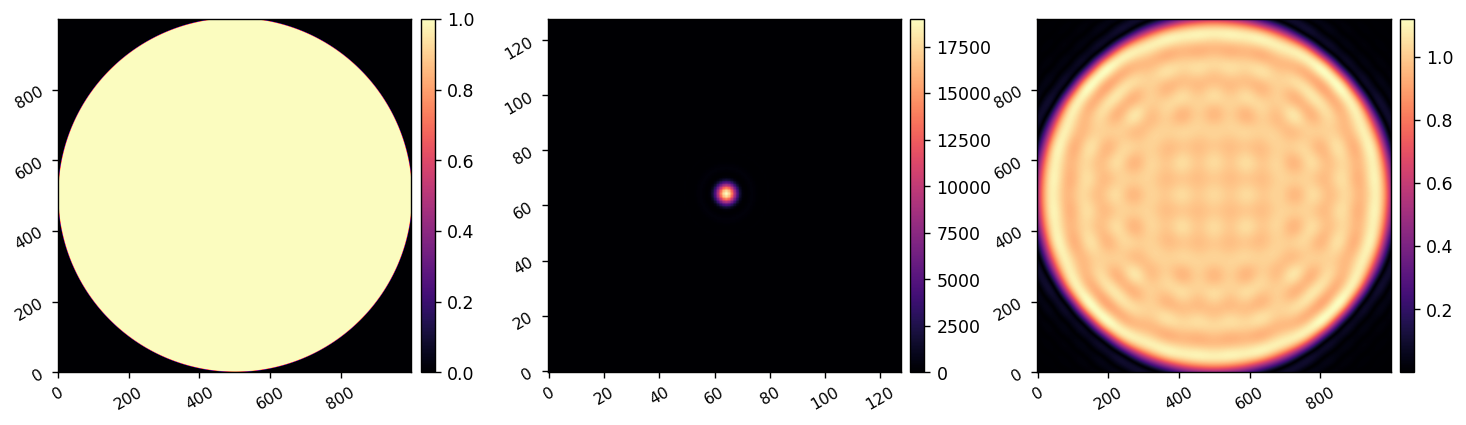

18972.728160207946


In [8]:
reload(fraunhofer)
fpwf1 = props.mft_forward(model.APERTURE, model.psf_pixelscale_lamD, model.npsf)
ppwf1 = props.mft_reverse(fpwf1, model.psf_pixelscale_lamD, model.npix)
imshow3(model.APERTURE, xp.abs(fpwf1)**2, xp.abs(ppwf1))
print(xp.max(xp.abs(fpwf1)**2))



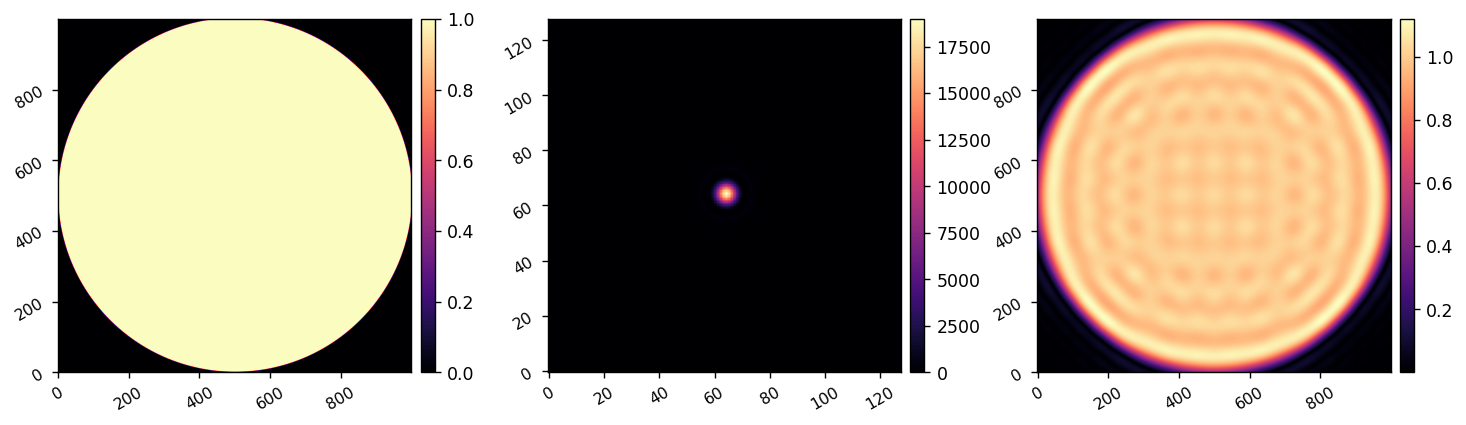

18972.728160207946


In [102]:
reload(fraunhofer)
nlamD = model.psf_pixelscale_lamD * model.npsf
fpwf2 = poppy.matrixDFT.matrix_dft(model.APERTURE, nlamD, model.npsf, inverse=False, centering='FFTSTYLE')
ppwf2 = poppy.matrixDFT.matrix_dft(fpwf2, nlamD, model.npix, inverse=True, centering='FFTSTYLE')
imshow3(model.APERTURE, xp.abs(fpwf2)**2, xp.abs(ppwf2))
print(xp.max(xp.abs(fpwf2)**2))

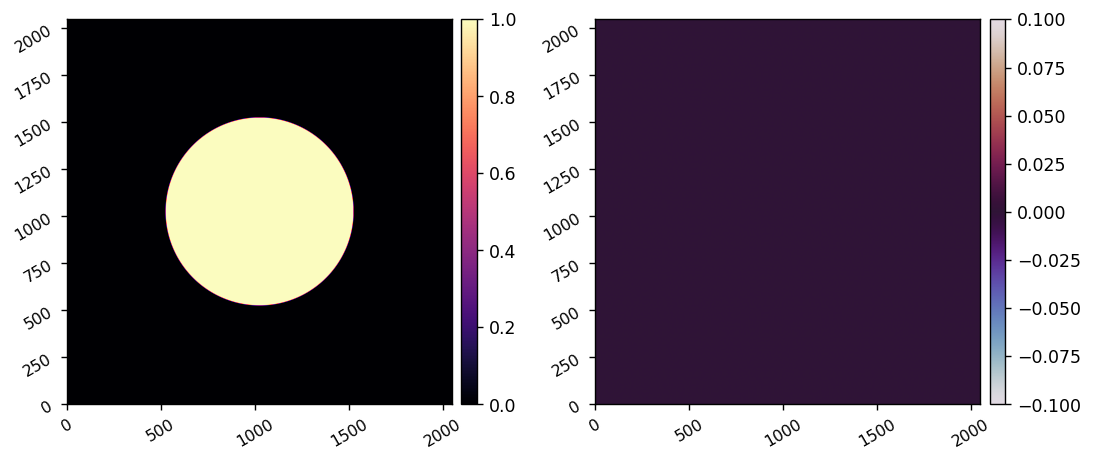

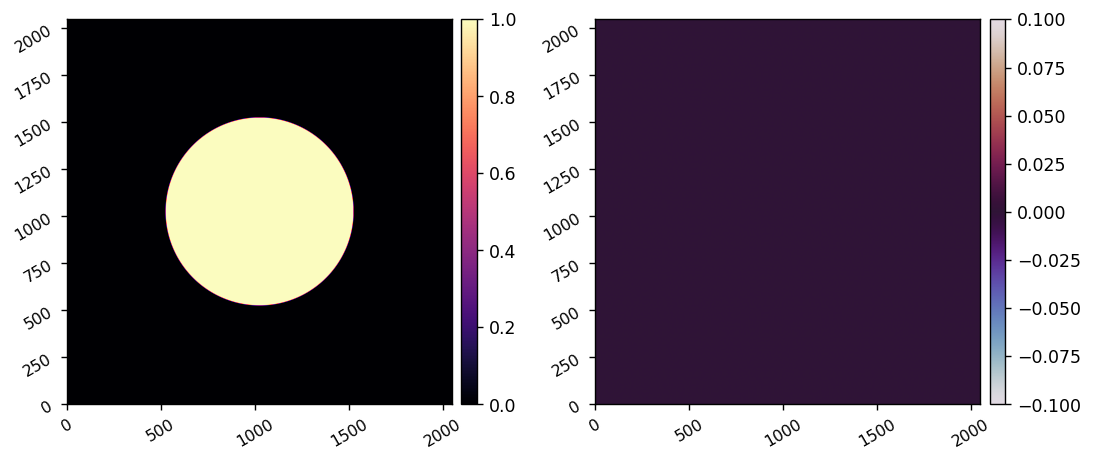

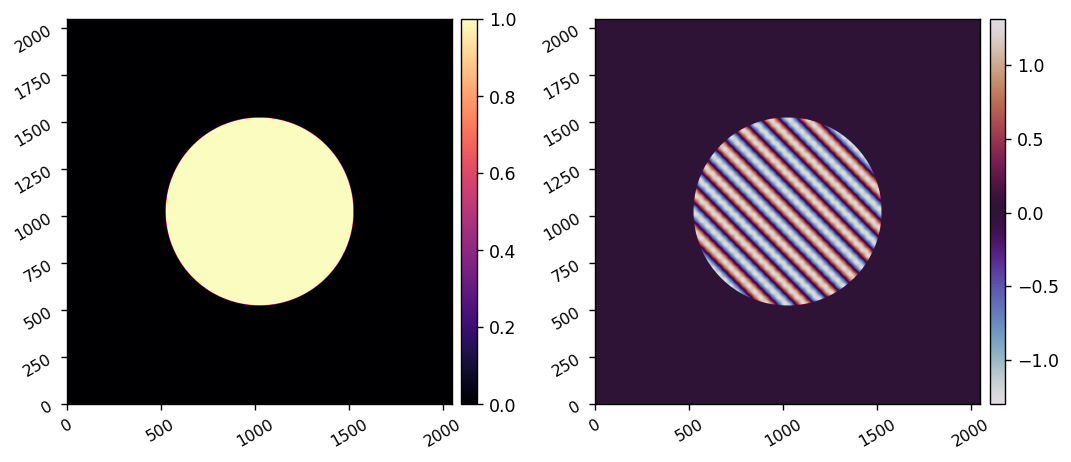

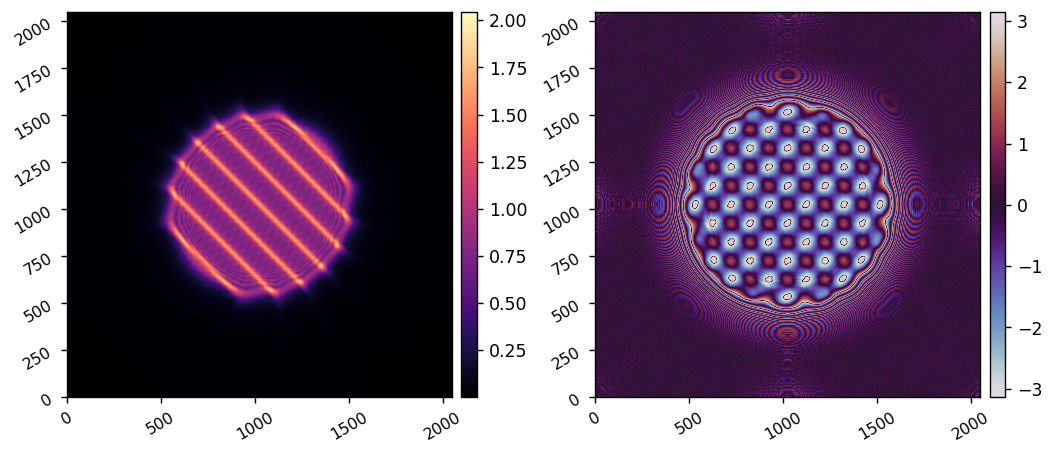

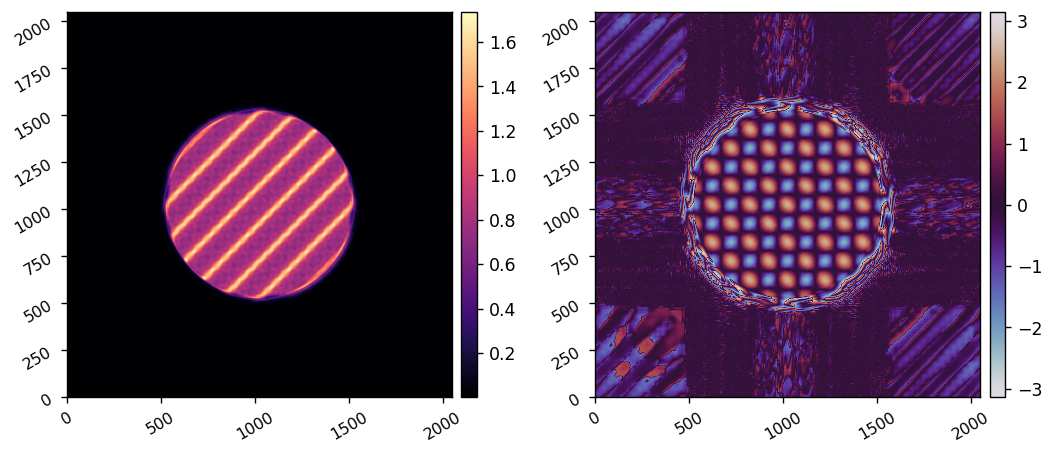

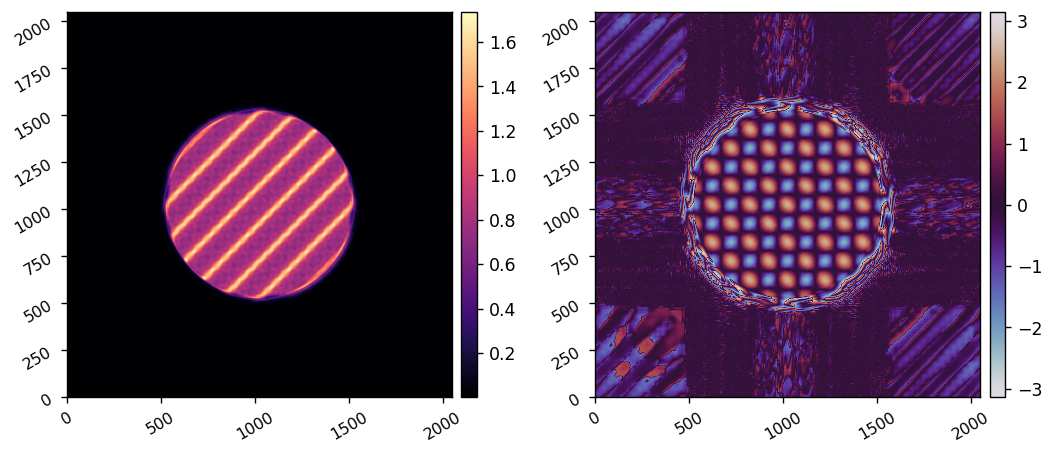

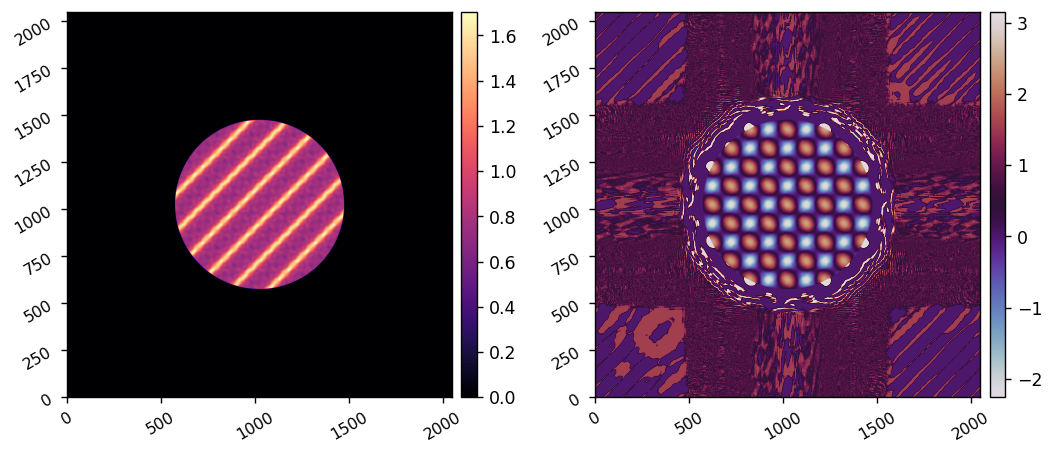

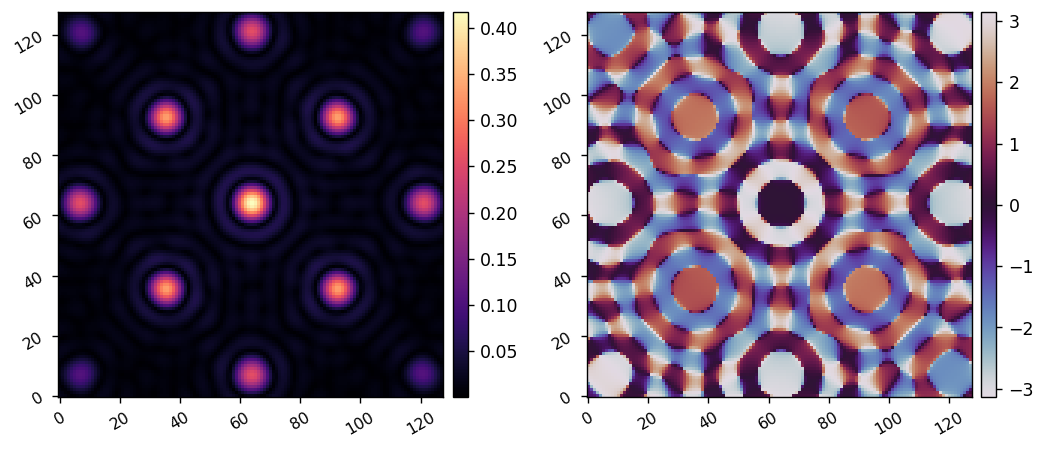

In [3]:
for i,wf in enumerate(wfs):
    imshow2(xp.abs(wf), xp.angle(wf),
            cmap1='magma', cmap2='twilight')